In [1]:
import cv2 as cv

from matplotlib import pyplot as plt
import networkx as nx

import numpy as np

In [2]:
def reduce_points(points,thresh):
    for point in points:
        if((point!=0).all()):
            dist = np.sum(np.square(points-point),axis=1)
            points[np.logical_and(dist>0,dist<thresh)]=0
            
    points = points.tolist()
    points = [i for i in points if i!=[0,0]]
    return np.array(points)

In [3]:
nonoise_vid = cv.VideoCapture('./1tagvideo.mp4')
if (nonoise_vid.isOpened() == False):
	print("Error opening the video file")
else:
  # Get frame rate information

  fps = int(nonoise_vid.get(5))
  print("Frame Rate : ",fps,"frames per second")	

  # Get frame count
  frame_count = nonoise_vid.get(7)
  print("Frame count : ", frame_count)


Frame Rate :  26 frames per second
Frame count :  787.0


In [4]:
frames = []
while(nonoise_vid.isOpened()):
	# nonoise_vid.read() methods returns a tuple, first element is a bool 
	# and the second is frame
  ret, frame = nonoise_vid.read()
  if ret == True:
    #Split the channels and invert color of the frame as we are only interested in the red channel
    frames.append(frame)
  else:
    break

### Converting image into frequency domain

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1356a1d2a88>)

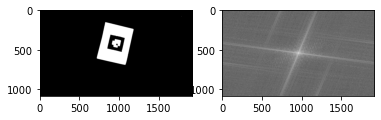

In [5]:
img1 = frames[0]
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray1 = cv.medianBlur(gray1,5) ## Remove noise

sharpen = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
gray1 = cv.filter2D(gray1,-1,sharpen) ##Sharpen the image to get the edges more promanent 

gray1 = np.float32(gray1>160) ## Threshold the image


##perform FFT 
f= np.fft.fft2(gray1)
f = np.fft.fftshift(f)
magnitude = 20*np.log(np.abs(f))

plt.subplot(2,2,1),plt.imshow(gray1,"gray")
plt.subplot(2,2,2),plt.imshow(magnitude,"gray")

### Making a bandpass filter

In [6]:
rows, cols = gray1.shape
crow, ccol = int(rows/2), int(cols/2)       ##Center Pixel
mask = np.zeros((rows, cols), np.uint8)     ##Create a mask that is the same size as that of the image
size1 = 200
size2 = 500
x, y = np.ogrid[:rows, :cols]
bandpass_filter = np.logical_and(((x - crow) ** 2 + (y - ccol) ** 2 >= size1 ** 2),
                           ((x - crow) ** 2 + (y - ccol) ** 2 <= size2 ** 2))       ## Generate the region of the mask that needs to be populated with ones
mask[bandpass_filter] = 1   ##Populate the image with 

### Inverse FFT

C:\Users\X1\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x13638c5fbc8>)

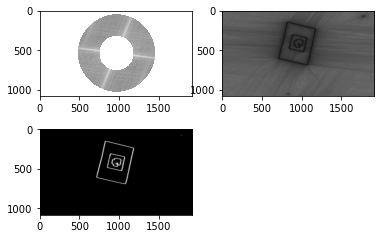

In [7]:
## Apply the mask to the FFT
iff_img = f*mask
ifft_mag = 20*np.log(np.abs(iff_img))   ##Masked FFT magnitude

iff_img = np.fft.ifftshift(iff_img)         
iff_img = np.fft.ifft2(iff_img)     ##Perform the inverse FFT


magnitude = -np.log(np.abs(iff_img))    ##Scale the magnitude of the image
magnitude *= (255.0/magnitude.max())    ##Normalize the image
magnitude_thre = np.float32(np.abs(magnitude-255)>220)  #Threshold and invert the image


plt.subplot(2,2,1),plt.imshow(ifft_mag,"gray")  ##Masked FFT 
plt.subplot(2,2,2),plt.imshow(magnitude,"gray") ##Magnitude of Masked IFFT
plt.subplot(2,2,3),plt.imshow(np.float32(magnitude_thre),"gray")    ##Threshold and inverted Image

### Marker detector

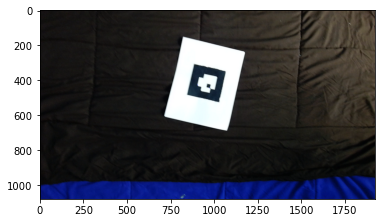

In [9]:
sharpen = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])

for imgs in frames:
    img = cv.medianBlur(imgs, 5)
    img = cv.filter2D(img,-1,sharpen) ##Sharpen the image to get the edges more promanent 
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    # gray = cv.threshold(gray,200,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    
    dx,dy = cv.spatialGradient(np.uint8(gray))
    G = np.hypot(dx, dy)
    G = G / G.max() * 255
    G = np.float32(G>100)
    theta = np.arctan2(dx, dy)
    
    break
plt.imshow(img)

# SCRATHPAD

In [147]:
dx,dy = cv.spatialGradient(np.uint8(gray))
G = np.hypot(dx, dy)
G = G / G.max() * 255
G = np.float32(G>100)
theta = np.arctan2(dx, dy)
Graphs = []
for i in np.argwhere(G>0):
    for g in Graphs:
        botton_node = np.array(list(nx.nodes(g))[-1])
        diff_grad = np.hypot(theta[botton_node],theta[i])
        if diff_grad.all()<0.01:
            g.add_node(tuple(botton_node),tuple(i),weight=diff_grad)
            break
    else:
        temp = nx.Graph()
        temp.add_node(tuple(i))
        Graphs.append(temp)
    

IndexError: index 1772 is out of bounds for axis 0 with size 1080

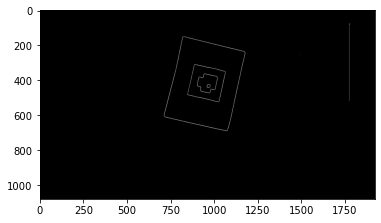

In [29]:
plt.imshow(G,"gray")

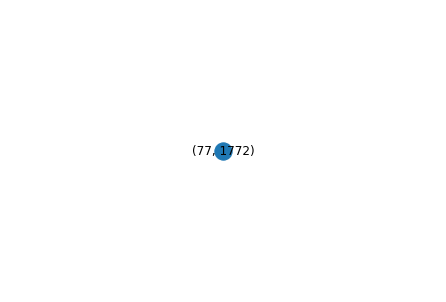

In [137]:
nx.draw(Graphs[0],with_labels=True)

In [144]:
np.array(list(nx.nodes(Graphs[0]))[-1])

array([  77, 1772], dtype=int64)